# EXPLORE DATABASE

In [1]:
import psycopg2
import pandas as pd
import geopandas as gpd
import datetime as dt
from shapely import wkt
from shapely.geometry import box
import time
import matplotlib.pyplot as plt
from pathlib import Path
import matplotlib.image as mpimg

In [2]:
def divide_time(tot_time = None):
    """From a value in seconds divides into minutes and seconds"""
    if tot_time is None:
        return 0,0
    else:
        return tot_time//60, tot_time-(tot_time//60*60)
    
def make_long_query(params, table_name):
    start = time.time()
    query_pandas = f"""SELECT datetime, ST_AsText(geom) AS geom FROM {table_name}
                WHERE datetime > %(start_date)s AND datetime < %(end_date)s AND
                geom && ST_MakeEnvelope(%(wlon)s, %(slat)s, %(elon)s, %(nlat)s, 4326)
                ORDER BY datetime;"""
    with psycopg2.connect("dbname='wfdb' user='wfuser' host='localhost'") as conn:
    #     tabl = pd.read_sql_query("select * from gfas_cfire_flux ORDER BY datetime ASC LIMIT 10;",conn)
        tabl = pd.read_sql_query(query_pandas, conn,
                                params = params)
    tabl['geom'] = tabl.geom.apply(wkt.loads)
    tabl = gpd.GeoDataFrame(tabl[['datetime']], geometry = tabl['geom'])
    print(f'PANDAS: table {table_name}  processed in {time.time()-start:.03f} s')
    return tabl
    
    
def query_all_data_spatial_extent(table_name):
    start = time.time()
    query_pandas = f"""SELECT ST_AsText(geom) AS geom, COUNT(value) as counts, SUM(value) as sums FROM {table_name}
           GROUP BY geom;"""
    with psycopg2.connect("dbname='wfdb' user='wfuser' host='localhost'") as conn:
        tabl = pd.read_sql_query(query_pandas, conn)

    # CREATE shapefile
    tabl['geometry'] = tabl.geom.apply(wkt.loads)
    tabl = gpd.GeoDataFrame(tabl[[f for f in tabl.columns if f!='geometry']], geometry = tabl['geometry'], crs = 'EPSG:4326')
    print(f'PANDAS processed in {time.time()-start:.03f} s')
    t1 = time.time()-start

    # AGGREGATE BY CLUSTER
    start = time.time()
    #cluster by 0.5 DEG
    tabl['clust'] = [f'{xx}_{yy}' for xx,yy in zip(((tabl.geometry.x*2).round())/2,((tabl.geometry.y*2).round())/2)]
    dis_tabl = tabl.groupby('clust').sum()
    dis_tabl2 = dis_tabl.copy()
    def get_boxes_from_index(poi, buf = 0.25):
        xx,yy = [float(f) for f in poi.split('_')]
        return box(xx-buf, yy-buf, xx+buf, yy+buf)
    dis_tabl = tabl.groupby('clust').sum()
    dis_tabl2 = dis_tabl.copy()
    dis_tabl2['geometry'] = pd.Series(dis_tabl.index, index=dis_tabl.index).apply(get_boxes_from_index)
    print(f'CLUSTERING PROCESSED in {time.time()-start:.03f} s')
    t2 = time.time()-start
    return tabl, dis_tabl2, t1+t2

def plot_on_global_map(table, ax = None, outfile = None, column_name = 'sums*1e4',
                       legend_name = 'Cumulative values \nof total observations\n(quantiles*1e-4)',
                       title_name  = 'Total Spatial Distribution of the dataset'):
    # ss = tabl.groupby('clst_id').sum()
    outfile = '/home/esowc32//PROJECT/DATA/DatabaseData/IMAGES/CUMULATIVE VALUES_spatial_190522.png'
    if ax is None:
        fig, ax = plt.subplots(figsize = (10,5))
    ax.set_xlim(-180,180)
    ax.set_ylim(-90,90)        
    
    ax = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres')).sort_values('name').boundary.plot(ax=ax, zorder = 0,
                                                                                                       color = 'grey', alpha = 1)
    table.plot(column_name, ax=ax, cmap='RdYlBu_r', legend=True, scheme='quantiles', k= 10,
               legend_kwds = dict(loc='center left', bbox_to_anchor=(1, 0.5),
                                  title = legend_name, fmt = '{:.1e}'))
    ax.set_title(title_name, fontsize = 16)
    if outfile is not None:
        fig = ax.get_figure()
        fig.tight_layout()
        fig.savefig(outfile, facecolor = 'w', dpi = 300)
    return ax 
   
def compute_and_plot_timeseries_counts(table_name, ax = None, outfile = None):
    start = time.time()
    query_pandas = f"""SELECT datetime, COUNT(value) FROM {table_name}
    GROUP BY datetime ORDER BY datetime;"""
    with psycopg2.connect("dbname='wfdb' user='wfuser' host='localhost'") as conn:
        tabl2 = pd.read_sql_query(query_pandas, conn)
    print(f'PANDAS processed in {time.time()-start:.03f} s')
    t1 = time.time()-start
    mins, secs = divide_time(t1)
    
    # CHECK that there is no empty day in the database
    all_days = set(pd.date_range(tabl2.datetime.values[0],tabl2.datetime.values[-1]))
    database_days = set(tabl2.datetime) 
    if not len(all_days-database_days)==0:
        print(f"N#{len(all_days-database_days)} missing days for {table_name}!!")
        
    # PLOT Database
    if ax is None:
        fig, ax = plt.subplots(figsize = (15,8))
    ax = tabl2.plot(x = 'datetime', y = 'count', ax=ax)
    ax.set_title(f"{table_name} #days = {len(tabl2)}\n(From {str(tabl2.datetime.values[0]).split('T')[0]} To {str(tabl2.datetime.values[-1]).split('T')[0]}, # missing days = {len(all_days-database_days)})\n time to query {mins:.0f}m {secs:.0f}s")
    if outfile is not None:
        fig.savefig(outfile, facecolor = 'w')
    return ax

In [3]:
table_database = [
    ('co2fire'  , 'Wildfire flux of Carbon Dioxide'           , 'gfas_co2fire_data',  'kg/day',),                   
    ('cofire'   , 'Wildfire flux of Carbon Monoxide'          , 'gfas_cofire_data',   'kg/day',),                                                        
    ('ch4fire'  , 'Wildfire flux of Methane'                  , 'gfas_ch4fire_data',  'kg/day',),                                               
    ('noxfire'  , 'Wildfire flux of Nitrogen Oxides NOx'      , 'gfas_noxfire_data',  'kg/day',),                              
    ('pm2p5fire', 'Wildfire flux of Particulate Matter PM2.5' , 'gfas_pm2p5fire_data','kg/day',),                                  
    ('tpmfire'  , 'Wildfire flux of Total Particulate Matter' , 'gfas_tpmfire_data',  'kg/day',),                      
    ('tcfire'   , 'Wildfire flux of Total Carbon in Aerosols' , 'gfas_tcfire_data',   'kg/day',),                               
    ('ocfire'   , 'Wildfire flux of Organic Carbon'           , 'gfas_ocfire_data',   'kg/day',),               
    ('bcfire'   , 'Wildfire flux of Black Carbon'             , 'gfas_bcfire_data',   'kg/day',),                              
    ('cfire'    , 'Wildfire overall flux of burnt Carbon'     , 'gfas_cfire_data',    'kg/day',),                                   
    ('frpfire'  , 'Wildfire radiative power'                  , 'gfas_frpfire_data',  'W',),                    
    ('nh3fire'  , 'Wildfire Flux of Ammonia (NH3)'            , 'gfas_nh3fire_data',  'kg/day',)
]       

(nlat, slat, wlon, elon) = (90, -90, -180, 180)
params = {
            'start_date': dt.datetime(2003, 1, 1),
            'end_date': dt.datetime(2003, 1, 9),
            'nlat': nlat,
            'slat': slat,
            'wlon': wlon,
            'elon': elon
        }

## CHECK SPATIAL EXTENT: group by geometry all data

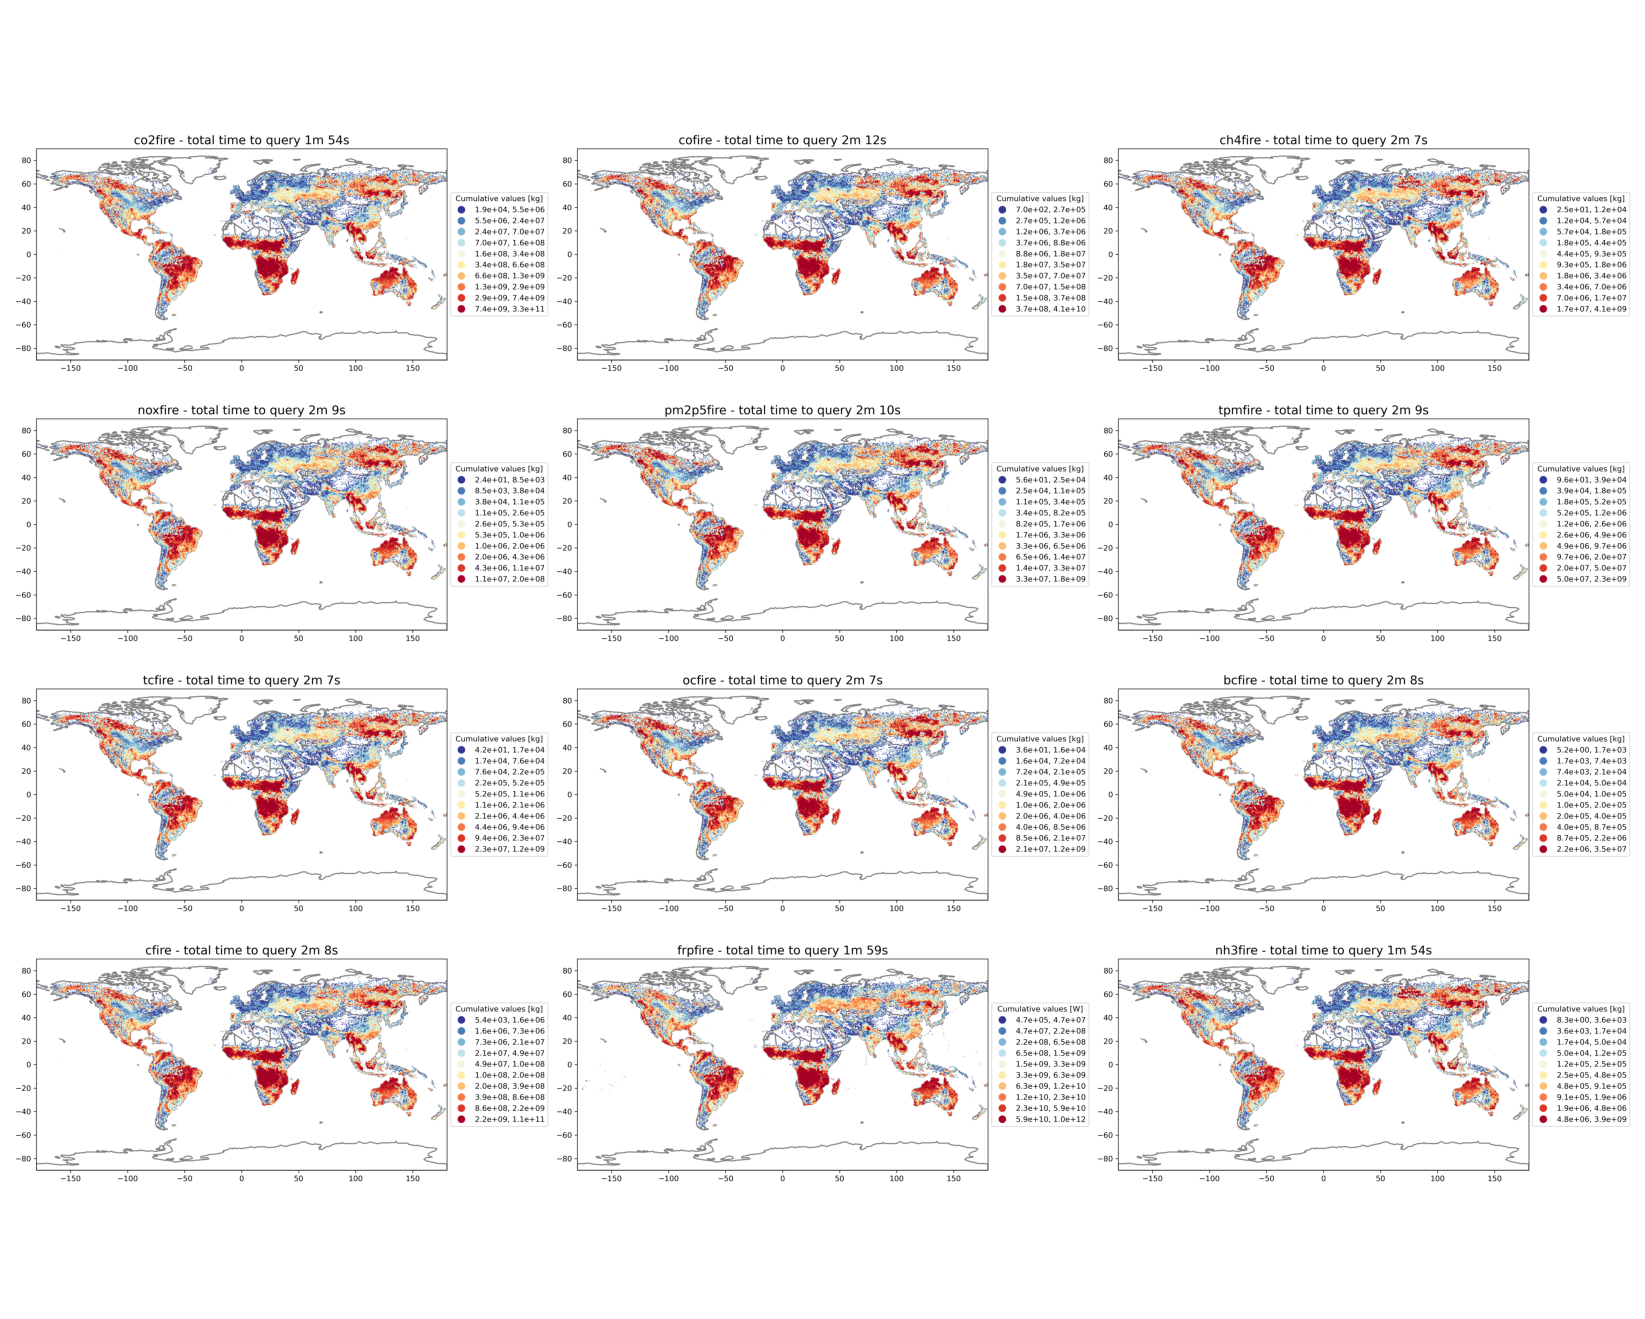

In [4]:
outfile = '/home/esowc32//PROJECT/DATA/DatabaseData/IMAGES/CUMULATIVE_VALUES_all_variables_230622.png'
if not Path(outfile).exists():
    fig, axs = plt.subplots(4,3, figsize = (15*2,12*2))
    for it, (var_name, description, table_name, measurement_units) in enumerate(table_database):
    #     tabl = make_long_query(params, table_name)
        tabl, dis_tabl2, tot_time = query_all_data_spatial_extent(table_name)
        legend_name = f"Cumulative values [{measurement_units.replace('/day','')}]"
        mins, secs = divide_time(tot_time)
        title_name  = f'{var_name} - total time to query {mins:.0f}m {secs:.0f}s'
        ax = plot_on_global_map(dis_tabl2,
                                ax = axs[it//3, it - it//3*3],
                                outfile = None,
                                column_name = 'sums',
                           legend_name = legend_name,
                           title_name  = title_name)
    fig.tight_layout()
    fig.savefig(outfile, facecolor = 'w', dpi = 300)
else:
    fig, ax = plt.subplots(figsize = (15*2,12*2))
    im = ax.imshow(mpimg.imread(outfile))
    ax.axis('off')
    plt.show()

# CHECK temporal extent

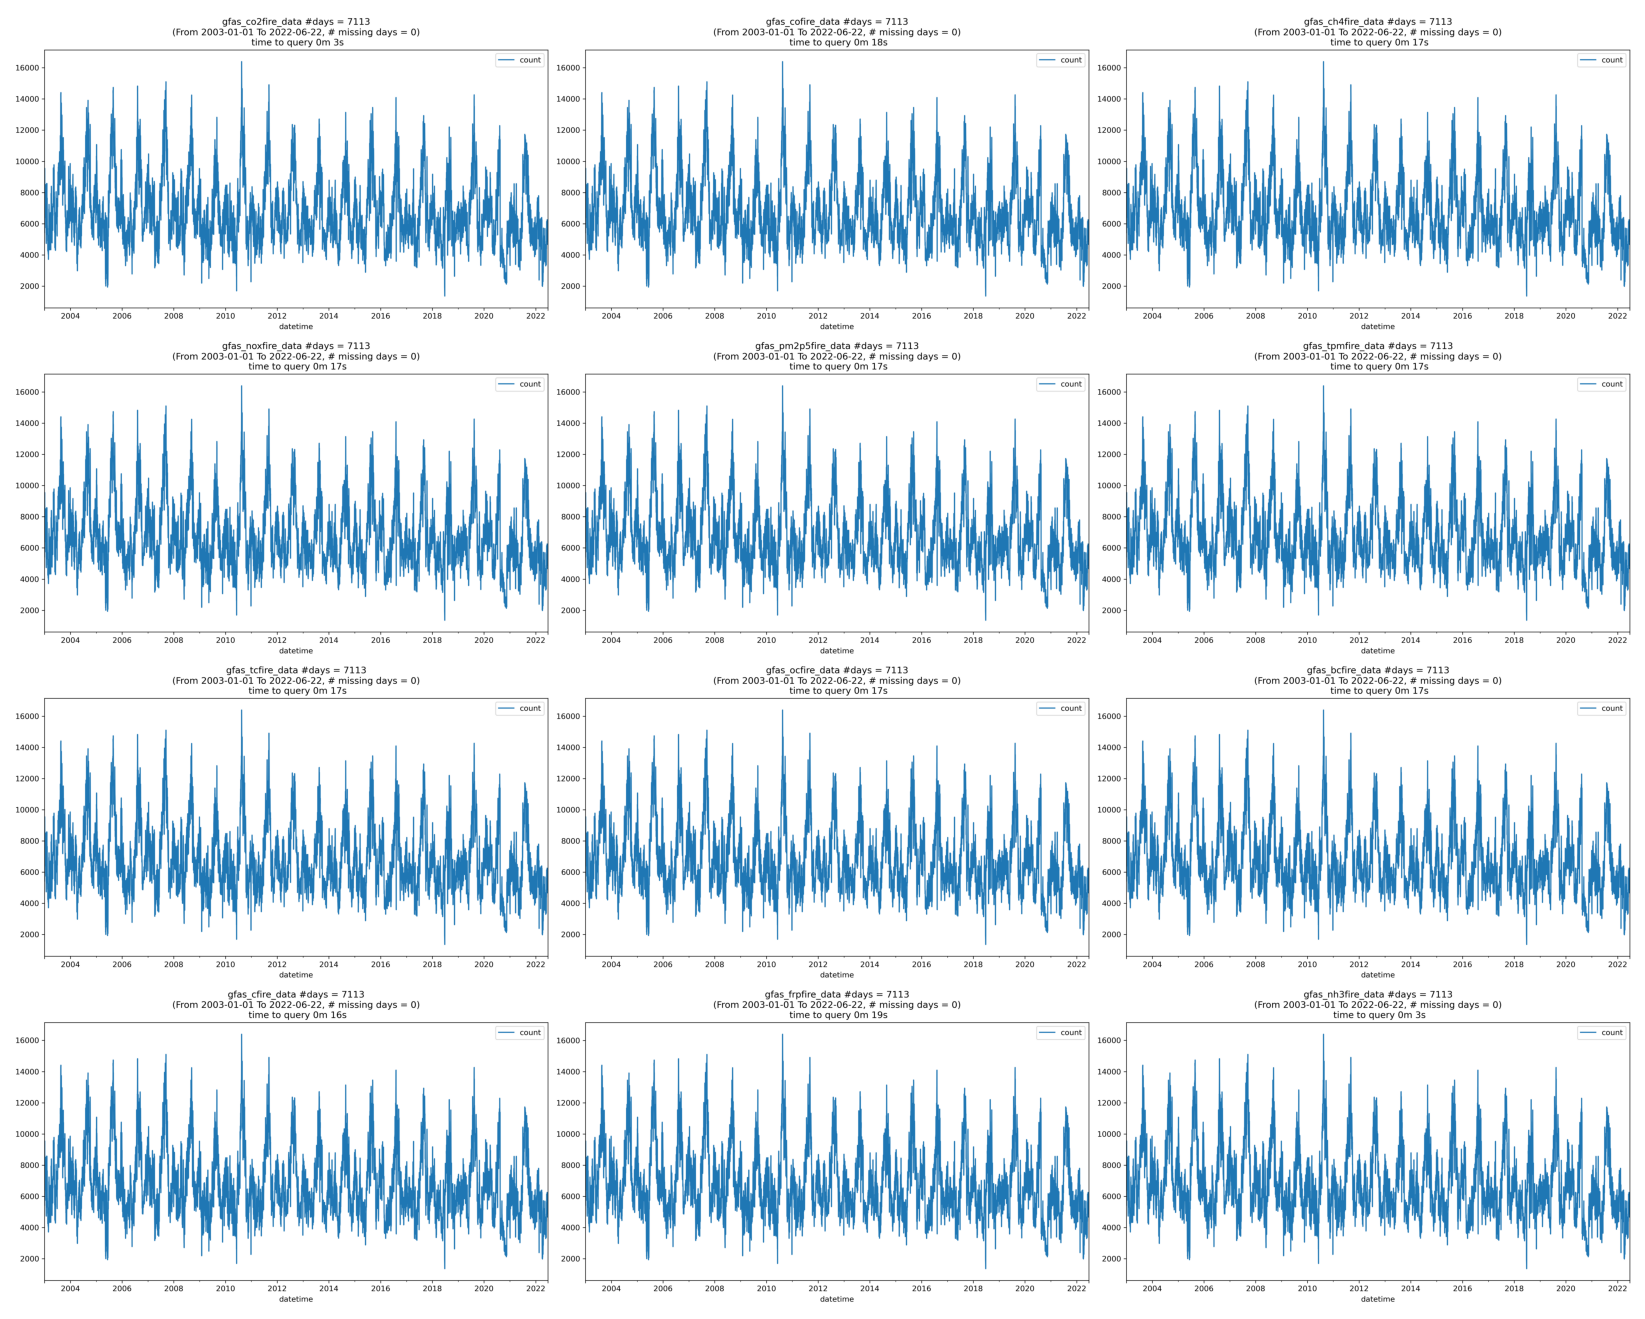

In [5]:
outfile2 = '/home/esowc32//PROJECT/DATA/DatabaseData/IMAGES/temporal_extension_all_variables_230622.png'
if not Path(outfile2).exists():
    fig2, axs2 = plt.subplots(4,3, figsize = (15*2,12*2))
    for it, (var_name, description, table_name, measurement_units) in enumerate(table_database):
        compute_and_plot_timeseries_counts(table_name, ax =axs2[it//3, it - it//3*3])
    fig2.tight_layout()
    fig2.savefig(outfile2, facecolor = 'w', dpi = 300)
else:
    fig, ax = plt.subplots(figsize = (15*2,12*2))
    im = ax.imshow(mpimg.imread(outfile2))
    ax.axis('off')
    plt.show()